<a href="https://colab.research.google.com/github/epodkwan/growthfunction/blob/main/notebooks/bsplinetrainer4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install flax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from functools import partial
import sys, os

os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

from typing import Sequence
import random
import statistics
import jax
import optax
import numpy as np
import jax.numpy as jnp
from jax import jit, vmap, grad
from flax import linen as nn
from flax.training import train_state, checkpoints
import matplotlib.pyplot as plt

sys.path.append('/content/drive/MyDrive/Colab Notebooks/growth/')
from conf import Configuration
from cosmology import Cosmology, SimpleLCDM, growth_integ
from growth_mlp_unnorm import Growth_MLP

In [ ]:
def npy_loader(path):
    return jnp.load(path)

In [ ]:
class SimpleMLP(nn.Module):
    features:Sequence[int]
    nodes:int

    @nn.compact
    def __call__(self, inputs):
        x=inputs
        for feat in self.features[:-2]:
            x=nn.Dense(feat)(x)
            x=nn.elu(x)
        t=nn.Dense(nodes-2)(nn.elu(nn.Dense(self.features[-2])(x)))
        c=nn.Dense(nodes+1)(nn.elu(nn.Dense(self.features[-1])(x)))
        t=jnp.concatenate([jnp.zeros((t.shape[0], 4)), jnp.cumsum(jax.nn.softmax(t), axis=1), jnp.ones((t.shape[0], 4))], axis=1)
        c=jnp.concatenate([jnp.zeros((c.shape[0], 1)), c], axis=1)
        return t, c

In [ ]:
@jit
def _deBoorVectorized(x, t, c):
    p=3
    k=jnp.digitize(x, t)-1
    d=[c[j+k-p] for j in range(0, p+1)]
    for r in range(1, p+1):
        for j in range(p, r-1, -1):
            alpha=(x-t[j+k-p])/(t[j+1+k-r]-t[j+k-p])
            d[j]=(1.0-alpha)*d[j-1]+alpha*d[j]
    return d[p]

deBoor=vmap(_deBoorVectorized, in_axes=(None, 0, 0))

In [ ]:
@jit
def eval_func(params, x, a):
    t, c=model.apply(params, x)
    preds=deBoor(jnp.clip(a, 0, 0.99999), t, c)
    return preds

In [ ]:
@jit
def D(a, cosmo):
    conf=cosmo.conf 
    a=jnp.asarray(a, dtype=conf.cosmo_dtype)
    D=a * jnp.interp(a, conf.growth_a, cosmo.growth[0][0])
    return D

In [ ]:
@jit
def objective_a(params, conf, a_test):
    omegam, omegak, w0, wa=params
    cosmo=SimpleLCDM(conf, Omega_m=omegam, Omega_k=omegak, w_0=w0, w_a=wa)
    cosmo=growth_integ(cosmo)
    obj=D(jnp.asarray(a_test), cosmo)
    return obj

In [ ]:
obj_grad_a=jit(grad(objective_a, argnums=(0)))
vmap_obj_grad_a=vmap(obj_grad_a, in_axes=(None, None, 0))
nc=32
cell_size=8
growth_anum=512
conf=Configuration(cell_size=cell_size, mesh_shape=(nc, )*3, growth_anum=growth_anum)
layer_sizes=[64, 64, 64]
nodes=8
learning_rate=1e-5
epochs=50000
model=SimpleMLP(features=layer_sizes, nodes=nodes)
temp=jnp.array([[1, 1, 1, 1]])
params=model.init(jax.random.PRNGKey(0), temp)
tx=optax.adam(learning_rate=learning_rate)
opt_state=tx.init(params)
target=400

In [ ]:
@jit
def mse_loss(params, x, y_ref, a):
    preds=eval_func(params, x, a)
    diff=preds-y_ref
    return jnp.mean(diff*diff)

In [ ]:
@jit
def train_step(opt_state, params, x, y_ref, a):
    loss, grads=jax.value_and_grad(mse_loss, argnums=0)(params, x, y_ref, a)
    updates, opt_state=tx.update(grads, opt_state)
    params=optax.apply_updates(params, updates)
    return loss, params, opt_state

In [ ]:
@jit
def epoch_step(x_train, y_train, params, opt_state, order, a):
    order=jax.random.permutation(jax.random.PRNGKey(i), order)
    train_loss=0
    for j in range(25):
        x_batch=x_train[order[32*j:32*(j+1)], :]
        y_batch=y_train[order[32*j:32*(j+1)], :]
        loss, params, opt_state=train_step(opt_state, params, x_batch, y_batch, a)
        train_loss=train_loss+loss
    return train_loss, params

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
os.chdir("/content/drive/My Drive/Colab Notebooks/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
input_data=npy_loader("./lindata"+str(target)+"/cosmo.npy")
input_result=npy_loader("./lindata"+str(target)+"/combined.npy")
a=npy_loader("./lindata"+str(target)+"/999.npy")[0, :]
# input_result=jnp.log(raw_input_result)
x_train=input_data[0:800].reshape(800, -1)
y_train=input_result[0:800, :]
x_validate=input_data[800:900].reshape(100, -1)
y_validate=input_result[800:900, :]

100 0.00039959172065233894
200 0.00029752570238926284
300 0.00022999038264964202
400 0.000184182797061851
500 0.00015982886503586064
600 0.0001478130648548627
700 0.00014118154156508522
800 0.0001359556710755186
900 0.0001309668331338386
1000 0.00012572745017913413
1100 0.00012045200165199452
1200 0.0001152990553198878
1300 0.00011032702923563076
1400 0.0001055541948721832
1500 0.00010101866340996108
1600 9.683236401180365e-05
1700 9.308410498255022e-05
1800 8.96209333963028e-05
1900 8.626899233435157e-05
2000 8.291820186107978e-05
2100 7.959205686089421e-05
2200 7.636075866915278e-05
2300 7.299822812634816e-05
2400 6.936768639155427e-05
2500 6.57947879903063e-05
2600 6.236896425486695e-05
2700 5.949842035522318e-05
2800 5.716483679171887e-05
2900 5.528056799118216e-05
3000 5.363772400030279e-05
3100 5.214104255665396e-05
3200 5.071934077794346e-05
3300 4.9396203206893735e-05
3400 4.820123699695799e-05
3500 4.713445937519105e-05
3600 4.617598908599164e-05
3700 4.5272920903680837e-05
38

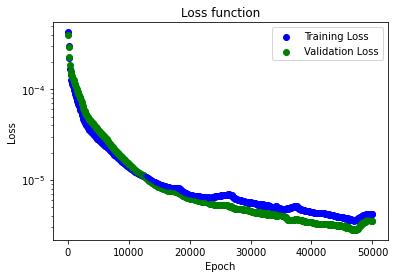

In [ ]:
os.chdir("/content/drive/My Drive/Colab Notebooks/elu+newstruct/")
order=jnp.arange(800)
for i in range(epochs):
    train_loss, params=epoch_step(x_train, y_train, params, opt_state, order, a)
    if i % 100 == 99:
        train_loss=train_loss/25
        validate_loss=mse_loss(params, x_validate, y_validate, a)
        print((i+1), validate_loss)
        plt.scatter((i+1), train_loss, c='b')
        plt.scatter((i+1), validate_loss, c='g')
print("Training ended")
checkpoints.save_checkpoint(ckpt_dir=("./"+str(target)+"/"), target=params, step=0, overwrite=True)
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss function")
plt.legend(["Training Loss", "Validation Loss"])
plt.savefig("./"+str(target)+"loss.png")

In [ ]:
params_class={}
for order in range(1, 3):
    for deriv in range(3):
        key="{}{}".format(order, deriv)
        params_class[key]=params
growth_fn=Growth_MLP(model, params_class)
growth_integ_jit=jit(growth_integ)
omega_m_test=0.3
omega_k_test=0.
w_0_test=-1.
w_a_test=0.
x_test=jnp.array([[omega_m_test, omega_k_test, w_0_test, w_a_test]])
a_test=jnp.linspace(0., 1., 100)
epsilon=1e-3

In [ ]:
@jit
def predict(cosmo, a):
    return growth_fn(cosmo, a).reshape(-1)[0]

In [ ]:
@jit
def gradient_at(cosmo, a):
    value1, gradient=jax.value_and_grad(predict, 0)(jnp.array([cosmo]), a)
    return value1, gradient

vmap_gradient_at=vmap(gradient_at, in_axes=(None, 0))

compile growth
compile boor


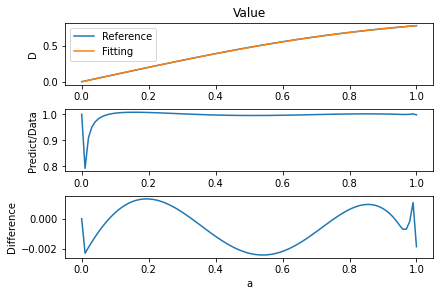

In [ ]:
cosmo_test=SimpleLCDM(conf, Omega_m=omega_m_test, Omega_k=omega_k_test, w_0=w_0_test, w_a=w_a_test)
cosmo_test=growth_integ_jit(cosmo_test)
d_data=D(a_test, cosmo_test)
d_test=growth_fn(x_test, a_test).reshape(-1)
discrepancy=(abs(d_test)+epsilon)/(abs(d_data)+epsilon)
fig, (ax1, ax2, ax3)=plt.subplots(3, 1, constrained_layout=True)
ax1.plot(a_test, d_data, label="Reference")
ax1.plot(a_test, d_test, label="Fitting")
ax1.set_ylabel("D")
ax1.legend()
ax1.set_title("Value")
ax2.plot(a_test, discrepancy)
ax2.set_ylabel("Predict/Data")
ax2.ticklabel_format(useOffset=False)
ax3.plot(a_test, d_test-d_data)
ax3.set_ylabel("Difference")
ax3.set_xlabel("a")
plt.savefig("./"+str(target)+"value.png")

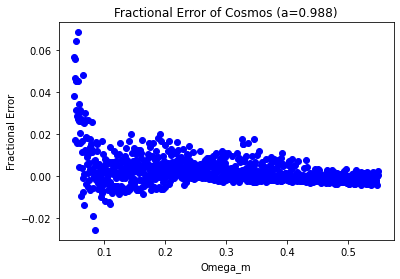

In [ ]:
a_plot=[]
mean_error=[]
for i in range(10):
    plt.clf()
    temp=[]
    for j in range(1000):
        d_data=input_result[j, i*28]
        d_test=growth_fn(jnp.array([input_data[j, :]]), a[i*28]).reshape(-1)
        temp.append(((abs(d_test)+epsilon)/(abs(d_data)+epsilon)-1).item())
        plt.scatter(input_data[j, 0], temp[-1], c='b')
    plt.xlabel("Omega_m")
    plt.ylabel("Fractional Error")
    plt.title("Fractional Error of Cosmos (a="+str(np.round(a[i*28].item(), 3))+")")
    plt.savefig("./"+str(target)+"error"+str(i)+".png")
    a_plot.append(a[i*28].item())
    mean_error.append(statistics.mean(temp))

<Figure size 432x288 with 0 Axes>

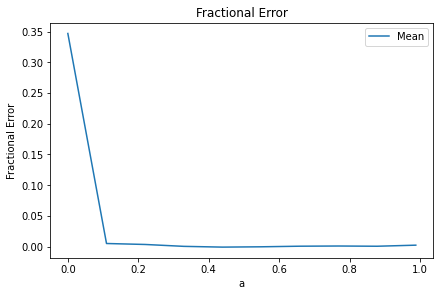

In [ ]:
plt.clf()
fig, ax=plt.subplots(constrained_layout=True)
ax.plot(a_plot, mean_error, label="Mean")
# ax.set_xscale('log')
ax.set_xlabel("a")
ax.set_ylabel("Fractional Error")
ax.set_title("Fractional Error")
ax.legend()
plt.savefig("./"+str(target)+"centralerror.png")

In [ ]:
plt.clf()
cosmo_test=[omega_m_test, omega_k_test, w_0_test, w_a_test]
value, grad=vmap_gradient_at(cosmo_test, a_test)
grad_test=grad
grad_ref=vmap_obj_grad_a(cosmo_test, conf, a_test)[0]
grad_ref=np.array(grad_ref).reshape(-1)
grad_test=np.array(grad_test).reshape(-1)
discrepancy=(abs(grad_test)+epsilon)/(abs(grad_ref)+epsilon)
fig, (ax1, ax2, ax3)=plt.subplots(3, 1, constrained_layout=True)
ax1.plot(a_test, grad_ref, label="Reference")
ax1.plot(a_test, grad_test, label="Neural Network")
ax1.legend()
ax1.set_title("Gradient")
ax2.plot(a_test, discrepancy)
ax2.set_ylabel("Predict/Data")
ax2.ticklabel_format(useOffset=False)
ax3.plot(a_test, grad_test-grad_ref)
ax3.set_ylabel("Difference")
ax3.set_xlabel("a")
plt.savefig("./"+str(target)+"gradient.png")

compile growth
compile boor


ValueError: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
max_error_ref=[]
max_error_test=[]
max_difference_ref=[]
max_difference_test=[]
for i in range(1000):
    value, grad_test=vmap_gradient_at([input_data[i, 0]], a_test)
    grad_ref=vmap_obj_grad_a([input_data[i, 0], omega_k_test, w_0_test, w_a_test], conf, a_test)[0]
    grad_ref=np.array(grad_ref).reshape(-1)
    grad_test=np.array(grad_test).reshape(-1)
    error=abs((abs(grad_test)+epsilon)/(abs(grad_ref)+epsilon)-1)
    difference=abs(grad_test-grad_ref)
    temp=jnp.where(error==jnp.max(error))
    max_error_ref.append(grad_ref[temp])
    max_error_test.append(grad_test[temp])
    temp=jnp.where(difference==jnp.max(difference))
    max_difference_ref.append(grad_ref[temp])
    max_difference_test.append(grad_test[temp])
max_error_ref=np.array(max_error_ref)
max_error_test=np.array(max_error_test)
max_difference_ref=np.array(max_difference_ref)
max_difference_test=np.array(max_difference_test)

compile growth


ScopeParamShapeError: ignored

In [ ]:
plt.clf()
fig, (ax1, ax2, ax3)=plt.subplots(3, 1, constrained_layout=True)
ax1.scatter(input_data[:, 0], (abs(max_error_test)+epsilon)/(abs(max_error_ref)+epsilon)-1)
ax1.set_ylabel("Fractional Error")
ax1.set_xlim(0.1, 0.5)
ax1.set_ylim(-1, 3)
ax1.set_title("Max Error")
ax2.scatter(input_data[:, 0], max_error_test-max_error_ref)
ax2.set_ylabel("Difference")
ax2.set_xlim(0.1, 0.5)
ax3.scatter(input_data[:, 0], max_error_ref)
ax3.set_ylabel("Gradient")
ax3.set_xlabel("Omega_m")
ax3.set_xlim(0.1, 0.5)
plt.ticklabel_format(useOffset=False)
plt.savefig("./"+str(target)+"maxerror.png")

In [ ]:
plt.clf()
fig, (ax1, ax2, ax3)=plt.subplots(3, 1, constrained_layout=True)
ax1.scatter(input_data[:, 0], max_difference_test-max_difference_ref)
ax1.set_ylabel("Difference")
ax1.set_xlim(0.1, 0.5)
ax1.set_title("Max Difference")
ax2.scatter(input_data[:, 0], (abs(max_difference_test)+epsilon)/(abs(max_difference_ref)+epsilon)-1)
ax2.set_ylabel("Fractional Error")
ax2.set_xlim(0.1, 0.5)
ax3.scatter(input_data[:, 0], max_difference_ref)
ax3.set_ylabel("Gradient")
ax3.set_xlabel("Omega_m")
ax3.set_xlim(0.1, 0.5)
plt.ticklabel_format(useOffset=False)
plt.savefig("./"+str(target)+"maxdifference.png")

In [ ]:
# drive.flush_and_unmount()